# Installers & imports

In [ ]:
!pip uninstall -y numpy
!pip install --no-cache-dir numpy==1.26.4


Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   ---- ----------------------------------- 1.8/15.8 MB 16.9 MB/s eta 0:00:01
   --------------- ------------------------ 6.0/15.8 MB 16.8 MB/s eta 0:00:01
   ------------------------- -------------- 10.2/15.8 MB 17.7 MB/s eta 0:00:01
   ----------------------------------- ---- 13.9/15.8 MB 17.8 MB/s eta 0:00:01
   ---------------------------------------- 15.8/15.8 MB 18.1 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
transformers 4.51.3 requires huggingface-hub<1.0,>=0.30.0, but you have huggingface-hub 0.24.7 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install numpy==1.24.4 monai==0.9.0 elasticdeform nibabel tensorboard tensorboardX \
    ml-collections einops timm opencv-python scipy tqdm matplotlib pandas glob2 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
transformers 4.51.3 requires huggingface-hub<1.0,>=0.30.0, but you have huggingface-hub 0.24.7 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install surface-distance


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Standard library
import os
import gc
import json
import random
from pathlib import Path
from functools import partial
from typing import Mapping, Hashable, Dict


# Utilities
from tqdm import tqdm
import psutil


# Scientific stack
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter, zoom


# Imaging / I/O / plotting
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
import elasticdeform


# Deep learning (PyTorch)
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR


# Evaluation metrics
from surface_distance import (
    compute_surface_distances,
    compute_surface_dice_at_tolerance,
)

# MONAI
import monai
from monai.config import KeysCollection
from monai.config.type_definitions import NdarrayOrTensor
from monai.data import Dataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.utils import one_hot
from monai.networks.nets import UNet
from monai.transforms import (
    MapTransform, RandomizableTransform, Compose, LoadImaged, AddChanneld,
    Orientationd, Spacingd, ScaleIntensityRanged, SpatialPadd,
    RandCropByPosNegLabeld, RandFlipd, RandRotate90d,
    RandScaleIntensityd, RandShiftIntensityd, ToTensord,
    CropForegroundd, RandSpatialCropd, NormalizeIntensityd,
    AsDiscrete, ResizeWithPadOrCropd, DivisiblePadd
)


# Tumor generation

## 1 - Location selection

In [ ]:
def random_select(mask_scan, image_scan=None):
    z_start, z_end = np.where(np.any(mask_scan, axis=(0, 1)))[0][[0, -1]]
    z = round(random.uniform(0.3, 0.7) * (z_end - z_start)) + z_start

    lung_mask = mask_scan[..., z]
    kernel = np.ones((5,5), dtype=np.uint8)
    lung_mask = cv2.erode(lung_mask, kernel, iterations=1)

    coordinates = np.argwhere(lung_mask == 1)

    #try 100 times, otherwise return xyz still
    for _ in range(100):
        idx = np.random.randint(0, len(coordinates))
        x, y = coordinates[idx]

        if image_scan is not None:
            local_patch = image_scan[x-2:x+3, y-2:y+3, z-1:z+2]  # patch 5x5x3

            # typical parenchima range
            local_mean = np.mean(local_patch)
            if -850 < local_mean < -300:
                return [x, y, z]

        else:
            return [x, y, z]

    # fallback
    return [x, y, z]


## 2 - Texture Generation

In [ ]:
def get_predefined_texture(mask_shape, sigma_a, sigma_b):
    a = np.random.uniform(0, 1, size=(mask_shape[0],mask_shape[1],mask_shape[2]))
    a_2 = gaussian_filter(a, sigma=sigma_a)

    scale = np.random.uniform(0.19, 0.21)
    base = np.random.uniform(0.04, 0.06)
    a =  scale * (a_2 - np.min(a_2)) / (np.max(a_2) - np.min(a_2)) + base


    random_sample = np.random.uniform(0, 1, size=(mask_shape[0],mask_shape[1],mask_shape[2]))
    b = (a > random_sample).astype(float)
    b = gaussian_filter(b, sigma_b)

    #here we increased the reference active texture to keep brighter version
    #-> solid nodules with bighter texture
    u_0 = np.random.uniform(0.7, 0.8)

    threshold_mask = b > 0.12
    beta = u_0 / (np.sum(b * threshold_mask) / threshold_mask.sum())
    Bj = np.clip(beta*b, 0, 1)

    return Bj


## 3 - Shape generation

In [ ]:
def get_ellipsoid(x, y, z):
    sh = (4*x, 4*y, 4*z)
    out = np.zeros(sh, int)
    aux = np.zeros(sh)
    radii = np.array([x, y, z])
    com = np.array([2*x, 2*y, 2*z])

    # calculate the ellipsoid
    bboxl = np.floor(com-radii).clip(0,None).astype(int)
    bboxh = (np.ceil(com+radii)+1).clip(None, sh).astype(int)
    roi = out[tuple(map(slice,bboxl,bboxh))]
    roiaux = aux[tuple(map(slice,bboxl,bboxh))]
    logrid = *map(np.square,np.ogrid[tuple(
            map(slice,(bboxl-com)/radii,(bboxh-com-1)/radii,1j*(bboxh-bboxl)))]),
    dst = (1-sum(logrid)).clip(0,None)
    mask = dst>roiaux
    roi[mask] = 1
    np.copyto(roiaux,dst,where=mask)

    return out

def get_fixed_geo(mask_scan, tumor_type):

    enlarge_x, enlarge_y, enlarge_z = 160, 160, 160
    geo_mask = np.zeros((mask_scan.shape[0] + enlarge_x, mask_scan.shape[1] + enlarge_y, mask_scan.shape[2] + enlarge_z), dtype=np.int8)
    tiny_radius, small_radius, medium_radius, large_radius = 6, 8, 10, 12

    if tumor_type == 'tiny':
        num_tumor = random.randint(3,10)
        for _ in range(num_tumor):
            # Tiny tumor
            x = random.randint(int(0.75*tiny_radius), int(1.25*tiny_radius))
            y = random.randint(int(0.75*tiny_radius), int(1.25*tiny_radius))
            z = random.randint(int(0.75*tiny_radius), int(1.25*tiny_radius))
            sigma = random.uniform(0.5,1)

            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo

    if tumor_type == 'small':
        num_tumor = random.randint(3,10)
        for _ in range(num_tumor):
            # Small tumor
            x = random.randint(int(0.75*small_radius), int(1.25*small_radius))
            y = random.randint(int(0.75*small_radius), int(1.25*small_radius))
            z = random.randint(int(0.75*small_radius), int(1.25*small_radius))
            sigma = random.randint(1, 2)

            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo

    if tumor_type == 'medium':
        num_tumor = random.randint(2, 5)
        for _ in range(num_tumor):
            # medium tumor
            x = random.randint(int(0.75*medium_radius), int(1.25*medium_radius))
            y = random.randint(int(0.75*medium_radius), int(1.25*medium_radius))
            z = random.randint(int(0.75*medium_radius), int(1.25*medium_radius))
            sigma = random.randint(3, 6)

            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo

    if tumor_type == 'large':
        num_tumor = random.randint(1,3)
        for _ in range(num_tumor):
            # Large tumor
            x = random.randint(int(0.75*large_radius), int(1.25*large_radius))
            y = random.randint(int(0.75*large_radius), int(1.25*large_radius))
            z = random.randint(int(0.75*large_radius), int(1.25*large_radius))
            sigma = random.randint(5, 10)

            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo

    if tumor_type == "mix":
        # tiny
        num_tumor = random.randint(3,10)
        for _ in range(num_tumor):
            # Tiny tumor
            x = random.randint(int(0.75*tiny_radius), int(1.25*tiny_radius))
            y = random.randint(int(0.75*tiny_radius), int(1.25*tiny_radius))
            z = random.randint(int(0.75*tiny_radius), int(1.25*tiny_radius))
            sigma = random.uniform(0.5,1)

            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            # paste small tumor geo into test sample
            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo

        # small
        num_tumor = random.randint(5,10)
        for _ in range(num_tumor):
            # Small tumor
            x = random.randint(int(0.75*small_radius), int(1.25*small_radius))
            y = random.randint(int(0.75*small_radius), int(1.25*small_radius))
            z = random.randint(int(0.75*small_radius), int(1.25*small_radius))
            sigma = random.randint(1, 2)

            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            # paste small tumor geo into test sample
            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo

        # medium
        num_tumor = random.randint(2, 5)
        for _ in range(num_tumor):
            # medium tumor
            x = random.randint(int(0.75*medium_radius), int(1.25*medium_radius))
            y = random.randint(int(0.75*medium_radius), int(1.25*medium_radius))
            z = random.randint(int(0.75*medium_radius), int(1.25*medium_radius))
            sigma = random.randint(3, 6)

            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo

        # large
        num_tumor = random.randint(1,3)
        for _ in range(num_tumor):
            # Large tumor
            x = random.randint(int(0.75*large_radius), int(1.25*large_radius))
            y = random.randint(int(0.75*large_radius), int(1.25*large_radius))
            z = random.randint(int(0.75*large_radius), int(1.25*large_radius))
            sigma = random.randint(5, 10)
            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo

    geo_mask = geo_mask[enlarge_x//2:-enlarge_x//2, enlarge_y//2:-enlarge_y//2, enlarge_z//2:-enlarge_z//2]
    geo_mask = (geo_mask * mask_scan) >=1

    return geo_mask

## 4 - Post-processing

In [ ]:
def get_tumor(volume_scan, mask_scan, tumor_type, texture):
    geo_mask = get_fixed_geo(mask_scan, tumor_type)

    sigma      = np.random.uniform(0.4, 0.7) #sharper borders
    difference = np.random.uniform(800, 1500)

    # blur the boundary
    geo_blur = gaussian_filter(geo_mask*1.0, sigma)

    #the texture is added -> this brightness the tumor regions
    #coherent for solid nodules
    abnormally = (volume_scan + texture * geo_blur * difference) * mask_scan

    abnormally_full = volume_scan * (1 - mask_scan) + abnormally
    abnormally_mask = mask_scan + geo_mask

    return abnormally_full, abnormally_mask

In [ ]:
def SynthesisTumor(volume_scan, mask_scan, tumor_type, texture):
    x_start, x_end = np.where(np.any(mask_scan, axis=(1, 2)))[0][[0, -1]]
    y_start, y_end = np.where(np.any(mask_scan, axis=(0, 2)))[0][[0, -1]]
    z_start, z_end = np.where(np.any(mask_scan, axis=(0, 1)))[0][[0, -1]]

    # shrink the boundary
    x_start, x_end = max(0, x_start+1), min(mask_scan.shape[0], x_end-1)
    y_start, y_end = max(0, y_start+1), min(mask_scan.shape[1], y_end-1)
    z_start, z_end = max(0, z_start+1), min(mask_scan.shape[2], z_end-1)

    lung_volume = volume_scan[x_start:x_end, y_start:y_end, z_start:z_end]
    lung_mask   = mask_scan[x_start:x_end, y_start:y_end, z_start:z_end]


    x_length, y_length, z_length = x_end - x_start, y_end - y_start, z_end - z_start
    start_x = random.randint(0, texture.shape[0] - x_length - 1) # random select the start point, -1 is to avoid boundary check
    start_y = random.randint(0, texture.shape[1] - y_length - 1)
    start_z = random.randint(0, texture.shape[2] - z_length - 1)
    cut_texture = texture[start_x:start_x+x_length, start_y:start_y+y_length, start_z:start_z+z_length]


    lung_volume, lung_mask = get_tumor(lung_volume, lung_mask, tumor_type, cut_texture)

    volume_scan[x_start:x_end, y_start:y_end, z_start:z_end] = lung_volume
    mask_scan[x_start:x_end, y_start:y_end, z_start:z_end] = lung_mask

    return volume_scan, mask_scan

##5 - MONAI transform definition

In [ ]:
class TumorGenerated(RandomizableTransform, MapTransform):
    def __init__(self,
    keys: KeysCollection,
    prob: float = 0.1,
    tumor_prob = [0.2, 0.2, 0.2, 0.2, 0.2],
    allow_missing_keys: bool = False
    ) -> None:
        MapTransform.__init__(self, keys, allow_missing_keys)
        RandomizableTransform.__init__(self, prob)
        random.seed(0)
        np.random.seed(0)

        self.tumor_types = ['tiny', 'small', 'medium', 'large', 'mix']

        assert len(tumor_prob) == 5
        self.tumor_prob = np.array(tumor_prob)
        # texture shape: 420, 300, 320
        # self.textures = pre_define 10 texture
        self.textures = []
        sigma_as = [3, 6, 9, 12, 15]
        sigma_bs = [4, 7]
        predefined_texture_shape = (512, 384, 384)
        for sigma_a in sigma_as:
            for sigma_b in sigma_bs:
                texture = get_predefined_texture(predefined_texture_shape, sigma_a, sigma_b)
                self.textures.append(texture)
        #print("All predefined texture have generated.")


    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        self.randomize(None)

        if self._do_transform and (np.max(d['label']) <= 1):
            tumor_type = np.random.choice(self.tumor_types, p=self.tumor_prob.ravel())
            texture = random.choice(self.textures)
            d['image'][0], d['label'][0] = SynthesisTumor(d['image'][0], d['label'][0], tumor_type, texture)
            #print(tumor_type, d['image'].shape, np.max(d['label']))
        return d

# Dataset

In [ ]:
json_path = r"C:\Users\aless\Desktop\DATASET_lung\converted_nii\LungNoduleFiltered_reduced.json"
base_dir = r"C:\Users\aless\Desktop\DATASET_lung"
roi_size = (160, 160, 160)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open(json_path) as f:
    splits = json.load(f)

def add_base_path(entries):
    return [
        {
            "image": os.path.join(base_dir, item["image"]),
            "label": os.path.join(base_dir, item["label"])
        }
        for item in entries
    ]

train_files = add_base_path(splits["training"])
val_files = add_base_path(splits["validation"])

train_files = [f for f in train_files if Path(f["image"]).exists() and Path(f["label"]).exists()]
val_files = [f for f in val_files if Path(f["image"]).exists() and Path(f["label"]).exists()]


train_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    DivisiblePadd(keys=["image", "label"], k=16),

    TumorGenerated(keys=["image", "label"], prob=0.9),

    ScaleIntensityRanged(
        keys=["image"], a_min=-1200, a_max=400,  #range tipico CT polmonari
        b_min=0.0, b_max=1.0, clip=True,
    ),

    RandFlipd(keys=["image", "label"], prob=0.2, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.2, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.2, spatial_axis=2),
    RandRotate90d(keys=["image", "label"], prob=0.2, max_k=3),
    RandScaleIntensityd(keys="image", factors=0.1, prob=0.15),
    RandShiftIntensityd(keys="image", offsets=0.1, prob=0.15),
    ToTensord(keys=["image", "label"]),
])


val_transform = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            AddChanneld(keys=["image", "label"]),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
            DivisiblePadd(keys=["image", "label"], k=16),
            ScaleIntensityRanged(keys=["image"], a_min=-1200, a_max=400, b_min=0.0, b_max=1.0, clip=True),
            ToTensord(keys=["image", "label"]),
        ]
    )

train_ds = Dataset(train_files, transform=train_transform)
val_ds = Dataset(val_files, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

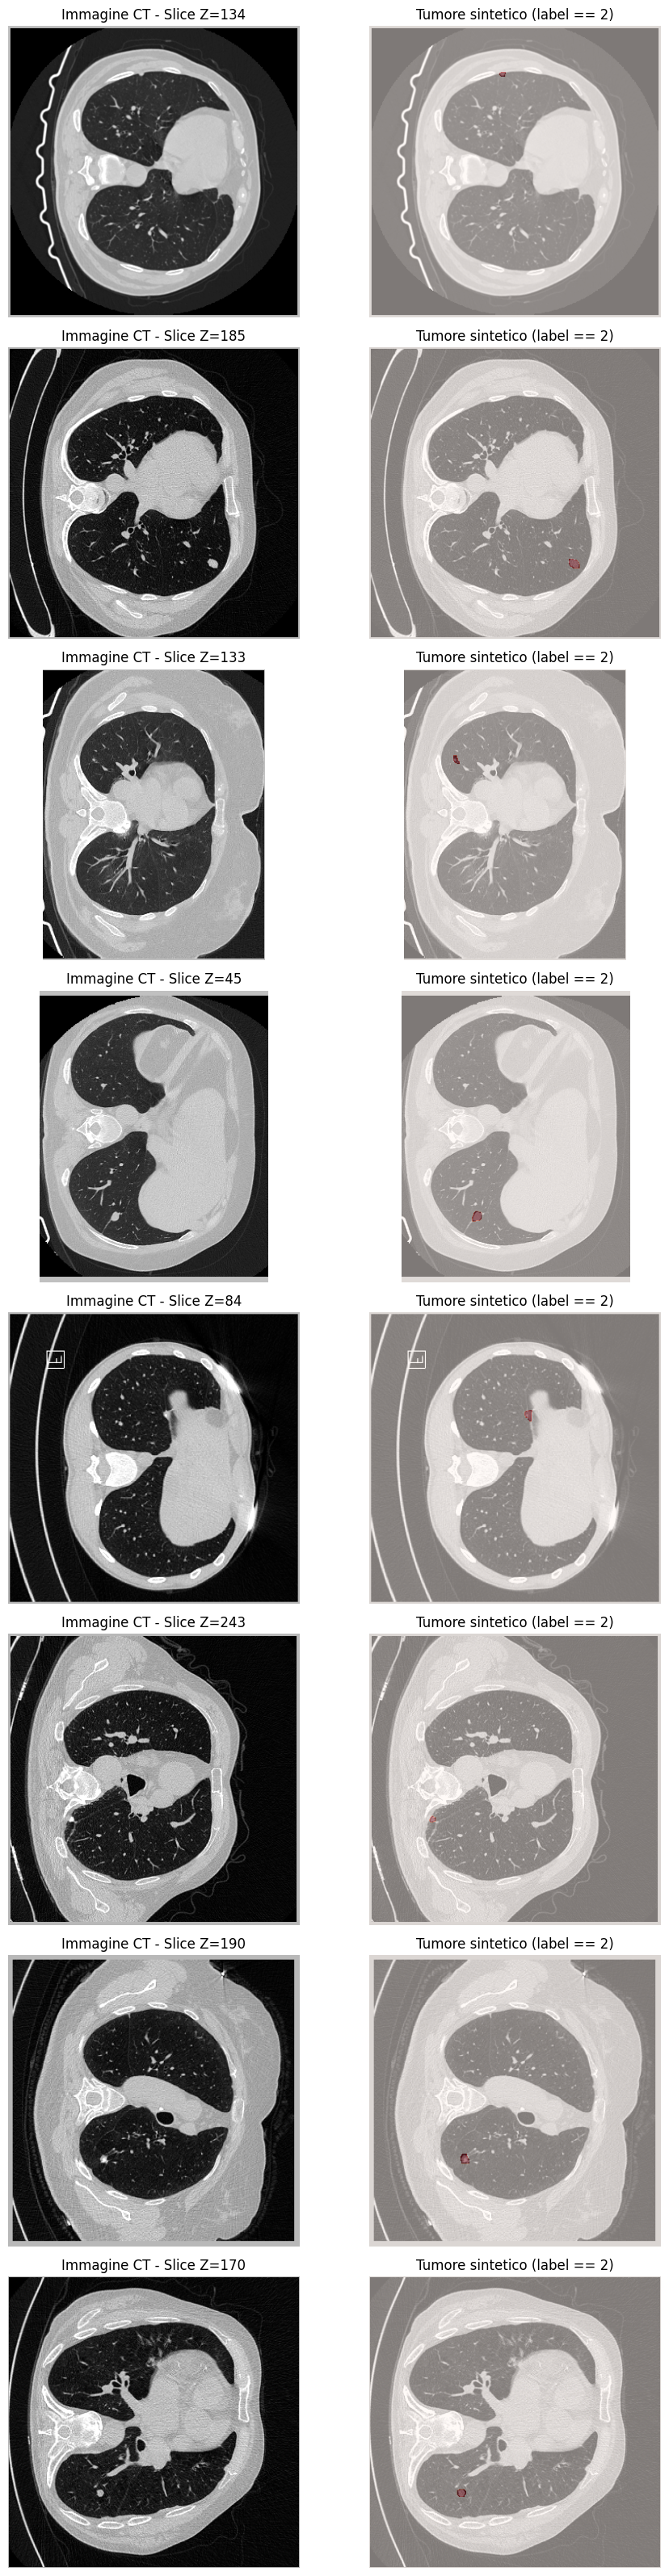

In [ ]:
def show_val_samples_with_tumor(val_loader, num_samples=3):
    plt.figure(figsize=(10, num_samples * 4))
    count = 0

    for batch in val_loader:
        image = batch["image"][0, 0].numpy()
        label = batch["label"][0, 0].numpy()


        z_slices_with_tumor = np.where(np.any(label == 2, axis=(0, 1)))[0]

        if len(z_slices_with_tumor) == 0:
            continue

        z_scores = [(z, np.sum(label[:, :, z] == 2)) for z in z_slices_with_tumor]
        z_max = max(z_scores, key=lambda x: x[1])[0]

        img_slice = image[:, :, z_max]
        label_slice = label[:, :, z_max]
        tumor_mask = (label_slice == 2).astype(float)

        plt.subplot(num_samples, 2, 2 * count + 1)
        plt.imshow(img_slice, cmap="gray")
        plt.title(f"Immagine CT - Slice Z={z_max}")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2 * count + 2)
        plt.imshow(img_slice, cmap="gray")
        plt.imshow(tumor_mask, cmap="Reds", alpha=0.5)
        plt.title("Tumore sintetico (label == 2)")
        plt.axis("off")

        count += 1
        if count >= num_samples:
            break

    plt.tight_layout()
    plt.show()

show_val_samples_with_tumor(val_loader, num_samples=8)


# Network (Unet 3D)

In [ ]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,  # 0: background, 1: lung, 2: nodule
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm='instance',
).to(device)

# Training

In [ ]:
def cal_dice(pred, true):
    intersection = np.sum(pred[true == 1]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true) + 1e-5)
    return dice

def cal_dice_nsd(pred, truth, spacing_mm=(1,1,1), tolerance=2):
    dice = cal_dice(pred, truth)
    surface_distances = compute_surface_distances(truth.astype(bool), pred.astype(bool), spacing_mm=spacing_mm)
    nsd = compute_surface_dice_at_tolerance(surface_distances, tolerance)
    return (dice, nsd)

# Loss combinata Dice + CE
loss_func = DiceCELoss(to_onehot_y=True, softmax=True)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)

# Inference con sliding window
model_inferer = lambda x: sliding_window_inference(
    inputs=x, roi_size=roi_size, sw_batch_size=1, predictor=model, overlap=0.75, mode="gaussian" #paper usa overlap di 0.75
)

In [ ]:
def train_epoch(model, loader, optimizer, loss_func, device):
    model.train()
    epoch_loss = 0
    for batch_data in tqdm(loader, desc="Training", leave=False):
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(loader)


def val_epoch(model, loader, loss_func, device, model_inferer):
    model.eval()
    epoch_loss = 0

    dice_liver_all = []
    dice_tumor_all = []

    with torch.no_grad():
        for i, batch_data in enumerate(tqdm(loader, desc="Validation", leave=False)):
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)

            outputs = model_inferer(inputs)
            loss = loss_func(outputs, labels)
            epoch_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            trues = labels.squeeze(1).cpu().numpy()

            pixdim = batch_data['label_meta_dict']['pixdim'].cpu().numpy()
            spacing_mm = tuple(pixdim[0][1:4])

            for pred, true in zip(preds, trues):
                dice_liver, _ = cal_dice_nsd(pred == 1, true == 1, spacing_mm)
                dice_tumor, _ = cal_dice_nsd(pred == 2, true == 2, spacing_mm)
                dice_liver_all.append(dice_liver)
                dice_tumor_all.append(dice_tumor)

            del inputs, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

    dice_liver_all = np.array(dice_liver_all)
    dice_tumor_all = np.array(dice_tumor_all)
    mean_dice = (dice_liver_all.mean() + dice_tumor_all.mean()) / 2

    return epoch_loss / len(loader), mean_dice, [dice_liver_all.mean(), dice_tumor_all.mean()]

In [ ]:
def run_training(
    model, train_loader, val_loader, optimizer, loss_func,
    model_inferer, device,
    max_epochs=50, val_every=1,
    logdir="./logs", save_ckpt=True,
    start_epoch=0, best_val_dice=-1,
    scheduler=None,
    #Early Stopping
    early_stop=True, early_stop_patience=5, early_stop_min_delta=0.0,
):
    os.makedirs(logdir, exist_ok=True)

    epochs_no_improve = 0  

    for epoch in range(start_epoch, max_epochs):
        print(f"\nEpoch {epoch+1}/{max_epochs}")

        train_loss = train_epoch(model, train_loader, optimizer, loss_func, device)
        print(f"  Train Loss: {train_loss:.4f}")

        # Save checkpoint (sempre)
        if save_ckpt:
            ckpt_name = f"checkpoint_epoch_{epoch+1}.pt"
            ckpt_path = os.path.join(logdir, ckpt_name)
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict() if scheduler is not None else None,
                "best_val_dice": best_val_dice,
                "hp": {
                    "max_epochs": max_epochs,
                    "warmup_epochs": 30,
                    "base_lr": 2e-4,
                    "eta_min": 1e-6,
                }
            }, ckpt_path)
            print(f" Checkpoint saved: {ckpt_name}")

        # Validation
        if (epoch + 1) % val_every == 0:
            val_loss, val_dice, dice_classes = val_epoch(model, val_loader, loss_func, device, model_inferer)

            dice_liver = dice_classes[0]
            dice_tumor = dice_classes[1]

            print(f"  Val Loss: {val_loss:.4f} | Mean Dice: {val_dice:.4f}")
            print(f"     - Dice Lung (class 1):  {dice_liver:.4f}")
            print(f"     - Dice Tumor (class 2):  {dice_tumor:.4f}")

            
            if val_dice > best_val_dice + early_stop_min_delta:
                best_val_dice = val_dice
                epochs_no_improve = 0  

                
                best_model_path = os.path.join(logdir, "best_model.pt")
                torch.save(model.state_dict(), best_model_path)
                print(f" Best model updated! Saved with Mean Dice: {val_dice:.4f}")
            else:
                epochs_no_improve += 1
                if early_stop:
                    print(f"  (no improvement: {epochs_no_improve}/{early_stop_patience})")
                    if epochs_no_improve >= early_stop_patience:
                        print(" Early stopping: patience ended.")
                        break  # interrompi training

        if scheduler is not None:
            scheduler.step()

    print(" Training finished.")


In [ ]:
run_training(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=loss_func,
    model_inferer=model_inferer,
    device=device,
    max_epochs=200,
    val_every=5,
    logdir=r"C:\Users\aless\Desktop\DATASET_lung\checkpoint",
    save_ckpt=True,
    best_val_dice=-1,
    scheduler=None        
)


Epoch 1/200


  Train Loss: 1.3832
 Checkpoint saved: checkpoint_epoch_1.pt

Epoch 2/200


  Train Loss: 1.0051
 Checkpoint saved: checkpoint_epoch_2.pt

Epoch 3/200


  Train Loss: 0.8058
 Checkpoint saved: checkpoint_epoch_3.pt

Epoch 4/200


  Train Loss: 0.6955
 Checkpoint saved: checkpoint_epoch_4.pt

Epoch 5/200


  Train Loss: 0.6042
 Checkpoint saved: checkpoint_epoch_5.pt


  Val Loss: 0.6398 | Mean Dice: 0.4620
     - Dice Lung (class 1):  0.9235
     - Dice Tumor (class 2):  0.0004
 Best model updated! Saved with Mean Dice: 0.4620

Epoch 6/200


  Train Loss: 0.5411
 Checkpoint saved: checkpoint_epoch_6.pt

Epoch 7/200


  Train Loss: 0.5256
 Checkpoint saved: checkpoint_epoch_7.pt

Epoch 8/200


  Train Loss: 0.4893
 Checkpoint saved: checkpoint_epoch_8.pt

Epoch 9/200


  Train Loss: 0.4579
 Checkpoint saved: checkpoint_epoch_9.pt

Epoch 10/200


  Train Loss: 0.4391
 Checkpoint saved: checkpoint_epoch_10.pt


  Val Loss: 0.5277 | Mean Dice: 0.4690
     - Dice Lung (class 1):  0.9379
     - Dice Tumor (class 2):  0.0002
 Best model updated! Saved with Mean Dice: 0.4690

Epoch 11/200


  Train Loss: 0.4279
 Checkpoint saved: checkpoint_epoch_11.pt

Epoch 12/200


  Train Loss: 0.4150
 Checkpoint saved: checkpoint_epoch_12.pt

Epoch 13/200


  Train Loss: 0.4062
 Checkpoint saved: checkpoint_epoch_13.pt

Epoch 14/200


  Train Loss: 0.4018
 Checkpoint saved: checkpoint_epoch_14.pt

Epoch 15/200


  Train Loss: 0.3990
 Checkpoint saved: checkpoint_epoch_15.pt


  Val Loss: 0.5541 | Mean Dice: 0.4598
     - Dice Lung (class 1):  0.9192
     - Dice Tumor (class 2):  0.0005
  (no improvement: 1/5)

Epoch 16/200


  Train Loss: 0.3899
 Checkpoint saved: checkpoint_epoch_16.pt

Epoch 17/200


  Train Loss: 0.3820
 Checkpoint saved: checkpoint_epoch_17.pt

Epoch 18/200


  Train Loss: 0.3759
 Checkpoint saved: checkpoint_epoch_18.pt

Epoch 19/200


  Train Loss: 0.3703
 Checkpoint saved: checkpoint_epoch_19.pt

Epoch 20/200


  Train Loss: 0.3676
 Checkpoint saved: checkpoint_epoch_20.pt


  Val Loss: 0.4695 | Mean Dice: 0.4872
     - Dice Lung (class 1):  0.9450
     - Dice Tumor (class 2):  0.0294
 Best model updated! Saved with Mean Dice: 0.4872

Epoch 21/200


  Train Loss: 0.3587
 Checkpoint saved: checkpoint_epoch_21.pt

Epoch 22/200


  Train Loss: 0.3476
 Checkpoint saved: checkpoint_epoch_22.pt

Epoch 23/200


  Train Loss: 0.3463
 Checkpoint saved: checkpoint_epoch_23.pt

Epoch 24/200


  Train Loss: 0.3283
 Checkpoint saved: checkpoint_epoch_24.pt

Epoch 25/200


  Train Loss: 0.3203
 Checkpoint saved: checkpoint_epoch_25.pt


  Val Loss: 0.5746 | Mean Dice: 0.4676
     - Dice Lung (class 1):  0.8938
     - Dice Tumor (class 2):  0.0414
  (no improvement: 1/5)

Epoch 26/200


  Train Loss: 0.4057
 Checkpoint saved: checkpoint_epoch_26.pt

Epoch 27/200


  Train Loss: 0.3890
 Checkpoint saved: checkpoint_epoch_27.pt

Epoch 28/200


  Train Loss: 0.3397
 Checkpoint saved: checkpoint_epoch_28.pt

Epoch 29/200


  Train Loss: 0.3099
 Checkpoint saved: checkpoint_epoch_29.pt

Epoch 30/200


  Train Loss: 0.2832
 Checkpoint saved: checkpoint_epoch_30.pt


  Val Loss: 0.4332 | Mean Dice: 0.5564
     - Dice Lung (class 1):  0.9473
     - Dice Tumor (class 2):  0.1655
 Best model updated! Saved with Mean Dice: 0.5564

Epoch 31/200


  Train Loss: 0.2418
 Checkpoint saved: checkpoint_epoch_31.pt

Epoch 32/200


  Train Loss: 0.2077
 Checkpoint saved: checkpoint_epoch_32.pt

Epoch 33/200


  Train Loss: 0.1702
 Checkpoint saved: checkpoint_epoch_33.pt

Epoch 34/200


  Train Loss: 0.1518
 Checkpoint saved: checkpoint_epoch_34.pt

Epoch 35/200


  Train Loss: 0.1708
 Checkpoint saved: checkpoint_epoch_35.pt


  Val Loss: 0.3972 | Mean Dice: 0.5347
     - Dice Lung (class 1):  0.9477
     - Dice Tumor (class 2):  0.1217
  (no improvement: 1/5)

Epoch 36/200


  Train Loss: 0.1218
 Checkpoint saved: checkpoint_epoch_36.pt

Epoch 37/200


  Train Loss: 0.1333
 Checkpoint saved: checkpoint_epoch_37.pt

Epoch 38/200


  Train Loss: 0.1117
 Checkpoint saved: checkpoint_epoch_38.pt

Epoch 39/200


  Train Loss: 0.1047
 Checkpoint saved: checkpoint_epoch_39.pt

Epoch 40/200


  Train Loss: 0.1006
 Checkpoint saved: checkpoint_epoch_40.pt


  Val Loss: 0.3741 | Mean Dice: 0.5699
     - Dice Lung (class 1):  0.9448
     - Dice Tumor (class 2):  0.1951
 Best model updated! Saved with Mean Dice: 0.5699

Epoch 41/200


  Train Loss: 0.0841
 Checkpoint saved: checkpoint_epoch_41.pt

Epoch 42/200


  Train Loss: 0.0993
 Checkpoint saved: checkpoint_epoch_42.pt

Epoch 43/200


  Train Loss: 0.0874
 Checkpoint saved: checkpoint_epoch_43.pt

Epoch 44/200


  Train Loss: 0.0871
 Checkpoint saved: checkpoint_epoch_44.pt

Epoch 45/200


  Train Loss: 0.0829
 Checkpoint saved: checkpoint_epoch_45.pt


  Val Loss: 0.3674 | Mean Dice: 0.5431
     - Dice Lung (class 1):  0.9539
     - Dice Tumor (class 2):  0.1322
  (no improvement: 1/5)

Epoch 46/200


  Train Loss: 0.0911
 Checkpoint saved: checkpoint_epoch_46.pt

Epoch 47/200


  Train Loss: 0.0983
 Checkpoint saved: checkpoint_epoch_47.pt

Epoch 48/200


  Train Loss: 0.0901
 Checkpoint saved: checkpoint_epoch_48.pt

Epoch 49/200


  Train Loss: 0.0944
 Checkpoint saved: checkpoint_epoch_49.pt

Epoch 50/200


  Train Loss: 0.1065
 Checkpoint saved: checkpoint_epoch_50.pt


  Val Loss: 0.3677 | Mean Dice: 0.5182
     - Dice Lung (class 1):  0.9626
     - Dice Tumor (class 2):  0.0739
  (no improvement: 2/5)

Epoch 51/200


  Train Loss: 0.0848
 Checkpoint saved: checkpoint_epoch_51.pt

Epoch 52/200


  Train Loss: 0.0706
 Checkpoint saved: checkpoint_epoch_52.pt

Epoch 53/200


  Train Loss: 0.0797
 Checkpoint saved: checkpoint_epoch_53.pt

Epoch 54/200


  Train Loss: 0.1128
 Checkpoint saved: checkpoint_epoch_54.pt

Epoch 55/200


  Train Loss: 0.0737
 Checkpoint saved: checkpoint_epoch_55.pt


  Val Loss: 0.3193 | Mean Dice: 0.5951
     - Dice Lung (class 1):  0.9662
     - Dice Tumor (class 2):  0.2241
 Best model updated! Saved with Mean Dice: 0.5951

Epoch 56/200


  Train Loss: 0.0619
 Checkpoint saved: checkpoint_epoch_56.pt

Epoch 57/200


  Train Loss: 0.0874
 Checkpoint saved: checkpoint_epoch_57.pt

Epoch 58/200


  Train Loss: 0.0687
 Checkpoint saved: checkpoint_epoch_58.pt

Epoch 59/200


  Train Loss: 0.0849
 Checkpoint saved: checkpoint_epoch_59.pt

Epoch 60/200


  Train Loss: 0.1222
 Checkpoint saved: checkpoint_epoch_60.pt


  Val Loss: 0.3983 | Mean Dice: 0.4945
     - Dice Lung (class 1):  0.9522
     - Dice Tumor (class 2):  0.0367
  (no improvement: 1/5)

Epoch 61/200


  Train Loss: 0.0749
 Checkpoint saved: checkpoint_epoch_61.pt

Epoch 62/200


  Train Loss: 0.0706
 Checkpoint saved: checkpoint_epoch_62.pt

Epoch 63/200


  Train Loss: 0.0677
 Checkpoint saved: checkpoint_epoch_63.pt

Epoch 64/200


  Train Loss: 0.0930
 Checkpoint saved: checkpoint_epoch_64.pt

Epoch 65/200


  Train Loss: 0.0723
 Checkpoint saved: checkpoint_epoch_65.pt


  Val Loss: 0.3379 | Mean Dice: 0.5506
     - Dice Lung (class 1):  0.9676
     - Dice Tumor (class 2):  0.1336
  (no improvement: 2/5)

Epoch 66/200


  Train Loss: 0.0763
 Checkpoint saved: checkpoint_epoch_66.pt

Epoch 67/200


  Train Loss: 0.0867
 Checkpoint saved: checkpoint_epoch_67.pt

Epoch 68/200


  Train Loss: 0.0688
 Checkpoint saved: checkpoint_epoch_68.pt

Epoch 69/200


  Train Loss: 0.1004
 Checkpoint saved: checkpoint_epoch_69.pt

Epoch 70/200


  Train Loss: 0.0786
 Checkpoint saved: checkpoint_epoch_70.pt


  Val Loss: 0.3738 | Mean Dice: 0.5010
     - Dice Lung (class 1):  0.9651
     - Dice Tumor (class 2):  0.0370
  (no improvement: 3/5)

Epoch 71/200


  Train Loss: 0.0750
 Checkpoint saved: checkpoint_epoch_71.pt

Epoch 72/200


  Train Loss: 0.0759
 Checkpoint saved: checkpoint_epoch_72.pt

Epoch 73/200


  Train Loss: 0.0640
 Checkpoint saved: checkpoint_epoch_73.pt

Epoch 74/200


  Train Loss: 0.0656
 Checkpoint saved: checkpoint_epoch_74.pt

Epoch 75/200


  Train Loss: 0.0772
 Checkpoint saved: checkpoint_epoch_75.pt


  Val Loss: 0.3470 | Mean Dice: 0.5398
     - Dice Lung (class 1):  0.9648
     - Dice Tumor (class 2):  0.1148
  (no improvement: 4/5)

Epoch 76/200


  Train Loss: 0.0707
 Checkpoint saved: checkpoint_epoch_76.pt

Epoch 77/200


  Train Loss: 0.0729
 Checkpoint saved: checkpoint_epoch_77.pt

Epoch 78/200


  Train Loss: 0.0588
 Checkpoint saved: checkpoint_epoch_78.pt

Epoch 79/200


  Train Loss: 0.0642
 Checkpoint saved: checkpoint_epoch_79.pt

Epoch 80/200


  Train Loss: 0.0754
 Checkpoint saved: checkpoint_epoch_80.pt


  Val Loss: 0.3516 | Mean Dice: 0.5291
     - Dice Lung (class 1):  0.9657
     - Dice Tumor (class 2):  0.0924
  (no improvement: 5/5)
 Early stopping: patience ended.
 Training finished.


# Evaluation

In [ ]:
model.load_state_dict(torch.load(
    r"C:\Users\aless\Desktop\DATASET_lung\checkpoint\best_model.pt",
    map_location=device
))
model.eval()


liver_dice_list = []
tumor_dice_list = []


with torch.no_grad():
    for batch_data in tqdm(val_loader, desc="Evaluating Best Model (Manual Dice)"):
        images = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        outputs = model_inferer(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        gts = labels.squeeze(1).cpu().numpy()


        pixdim = batch_data['label_meta_dict']['pixdim'].cpu().numpy()
        spacing_mm = tuple(pixdim[0][1:4])  # (dx, dy, dz)


        for pred, true in zip(preds, gts):
            liver_dice, _ = cal_dice_nsd(pred == 1, true == 1, spacing_mm)
            tumor_dice, _ = cal_dice_nsd(pred == 2, true == 2, spacing_mm)
            liver_dice_list.append(liver_dice)
            tumor_dice_list.append(tumor_dice)


liver_dice_mean = np.mean(liver_dice_list)
tumor_dice_mean = np.mean(tumor_dice_list)
mean_dice = (liver_dice_mean + tumor_dice_mean) / 2

print("\n Results of the Best Model (Dice):")
print(f"   - Dice liver (Classe 1): {liver_dice_mean:.4f}")
print(f"   - Dice tumor (Classe 2): {tumor_dice_mean:.4f}")
print(f"   - Mean Dice: {mean_dice:.4f}")


Evaluating Best Model (Manual Dice): 100%|██████████| 22/22 [24:02<00:00, 65.57s/it]


 Results of the Best Model (Dice):
   - Dice liver (Classe 1): 0.9662
   - Dice tumor (Classe 2): 0.2241
   - Mean Dice: 0.5951


In [ ]:
# ====== UTILS ======
def dice_bin(a: np.ndarray, b: np.ndarray) -> float:
    inter = (a & b).sum()
    s = a.sum() + b.sum()
    return float((2*inter)/(s+1e-7)) if s>0 else 0.0

def overlay_segmentation(ct_slice, mask_slice, title, cmap="Reds", alpha=0.4):
    plt.imshow(ct_slice, cmap="gray")
    plt.imshow(mask_slice.astype(np.float32), cmap=cmap, alpha=alpha, vmin=0, vmax=1)
    plt.title(title)
    plt.axis("off")

roi_size   = (160, 160, 160)

#TRANSFORM
inference_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    DivisiblePadd(keys=["image", "label"], k=16),
    ScaleIntensityRanged(keys=["image"], a_min=-1200, a_max=400, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=["image", "label"]),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#MODELLO & PESI
model = UNet(
    spatial_dims=3, in_channels=1, out_channels=3,
    channels=(16,32,64,128,256), strides=(2,2,2,2), num_res_units=2, norm='instance'
).to(device)





Mean softmax [bg, lung, tumor]: [0.8677 0.1323 0.    ]
GT unique: [0. 1. 2.] | Pred unique: [0 1 2]
Lung vox GT/Pred: 4761391 4761804
Tumor vox GT/Pred: 791 370
Dice lung (vol):  0.9861
Dice tumor (vol): 0.6305
Slice z=150 (source: GT-top)


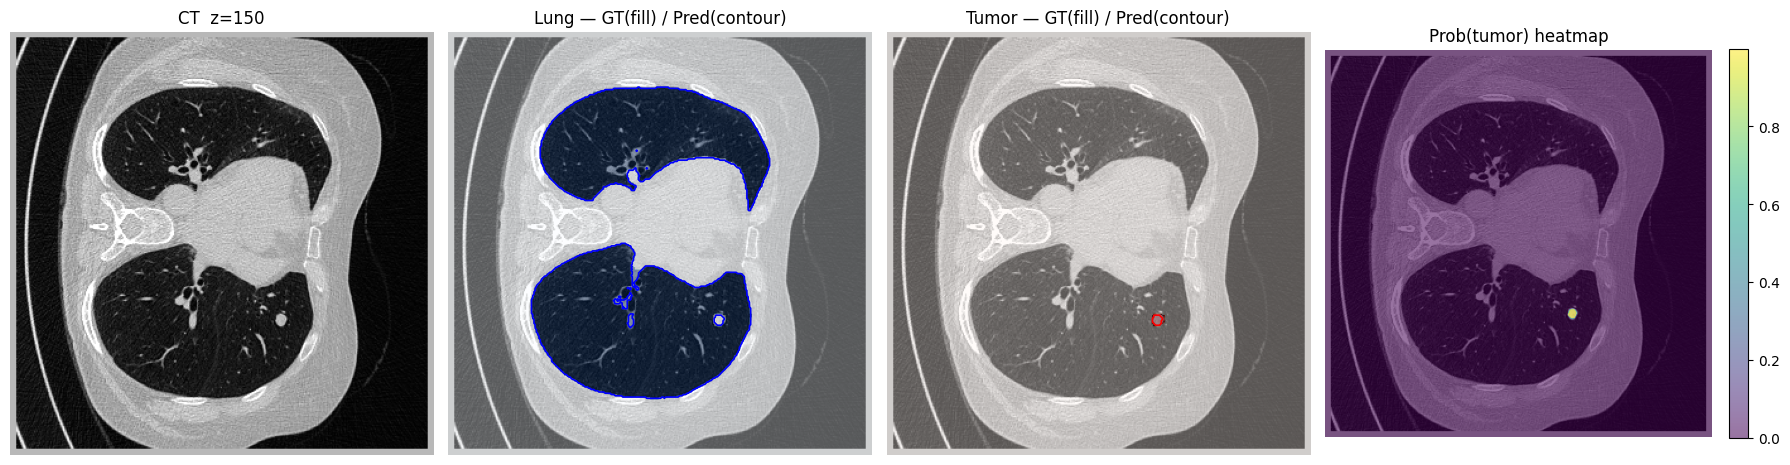

In [ ]:
#Good prediction

image_path = r"C:\Users\aless\Desktop\DATASET_lung\converted_nii\images\LNDb-0108.nii.gz"
label_path = r"C:\Users\aless\Desktop\DATASET_lung\converted_nii\multiclass\LNDb-0108.nii.gz"
model_path = r"C:\Users\aless\Desktop\DATASET_lung\checkpoint\best_model.pt"

data_dict = [{"image": image_path, "label": label_path}]
ds = Dataset(data=data_dict, transform=inference_transform)
loader = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)
state = torch.load(model_path, map_location=device)
if isinstance(state, dict) and "model_state_dict" in state:
    model.load_state_dict(state["model_state_dict"])
else:
    model.load_state_dict(state)
model.eval()
# ----------------------------

with torch.no_grad():
    batch = next(iter(loader))
    img_t = batch["image"].to(device)             # [1,1,H,W,D]
    lab   = batch["label"].cpu().numpy().squeeze()  # [H,W,D]
    img_np= img_t.cpu().numpy()[0,0]

    # sliding-window inference (come in training/val)
    logits = sliding_window_inference(
        inputs=img_t, roi_size=roi_size, sw_batch_size=1,
        predictor=model, overlap=0.75, mode="gaussian"
    )
    probs = torch.softmax(logits, dim=1)          # [1,3,H,W,D]
    pred  = torch.argmax(probs, dim=1).cpu().numpy().squeeze()

    ch_means = probs.mean(dim=(0,2,3,4)).cpu().numpy()
    print("Mean softmax [bg, lung, tumor]:", np.round(ch_means, 4))
    print("GT unique:", np.unique(lab), "| Pred unique:", np.unique(pred))
    print("Lung vox GT/Pred:", int((lab==1).sum()), int((pred==1).sum()))
    print("Tumor vox GT/Pred:", int((lab==2).sum()), int((pred==2).sum()))

    dl = dice_bin(pred==1, lab==1)
    dt = dice_bin(pred==2, lab==2)
    print(f"Dice lung (vol):  {dl:.4f}")
    print(f"Dice tumor (vol): {dt:.4f}")

    gt_area   = (lab==2).sum(axis=(0,1))
    pr_area   = (pred==2).sum(axis=(0,1))
    if gt_area.sum() > 0:
        z = int(np.argmax(gt_area)); src = "GT-top"
    elif pr_area.sum() > 0:
        z = int(np.argmax(pr_area)); src = "Pred-top"
    else:
        z = lab.shape[-1]//2;        src = "middle (no tumor)"
    print(f"Slice z={z} (source: {src})")

    ct   = img_np[:,:,z]
    gt_l = (lab==1)[:,:,z]
    gt_t = (lab==2)[:,:,z]
    pr_l = (pred==1)[:,:,z]
    pr_t = (pred==2)[:,:,z]
    p_t  = probs[0,2].cpu().numpy()[:,:,z]  # prob(tumor)

    plt.figure(figsize=(18,6))

    plt.subplot(1,4,1)
    plt.imshow(ct, cmap="gray")
    plt.title(f"CT  z={z}")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_l, "Lung — GT(fill) / Pred(contour)", cmap="Blues", alpha=0.35)
    if pr_l.any():
        plt.contour(pr_l.astype(np.float32), levels=[0.5], colors='blue', linewidths=1.2)

    plt.subplot(1,4,3)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_t, "Tumor — GT(fill) / Pred(contour)", cmap="Reds", alpha=0.35)
    if pr_t.any():
        plt.contour(pr_t.astype(np.float32), levels=[0.5], colors='red', linewidths=1.2)

    plt.subplot(1,4,4)
    plt.imshow(ct, cmap="gray")
    im = plt.imshow(p_t, alpha=0.55)
    plt.title("Prob(tumor) heatmap")
    plt.axis("off")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


Mean softmax [bg, lung, tumor]: [0.8165 0.1835 0.    ]
GT unique: [0. 1. 2.] | Pred unique: [0 1 2]
Lung vox GT/Pred: 5221938 4987007
Tumor vox GT/Pred: 1274 401
Dice lung (vol):  0.9705
Dice tumor (vol): 0.4549
Slice z=45 (source: GT-top)


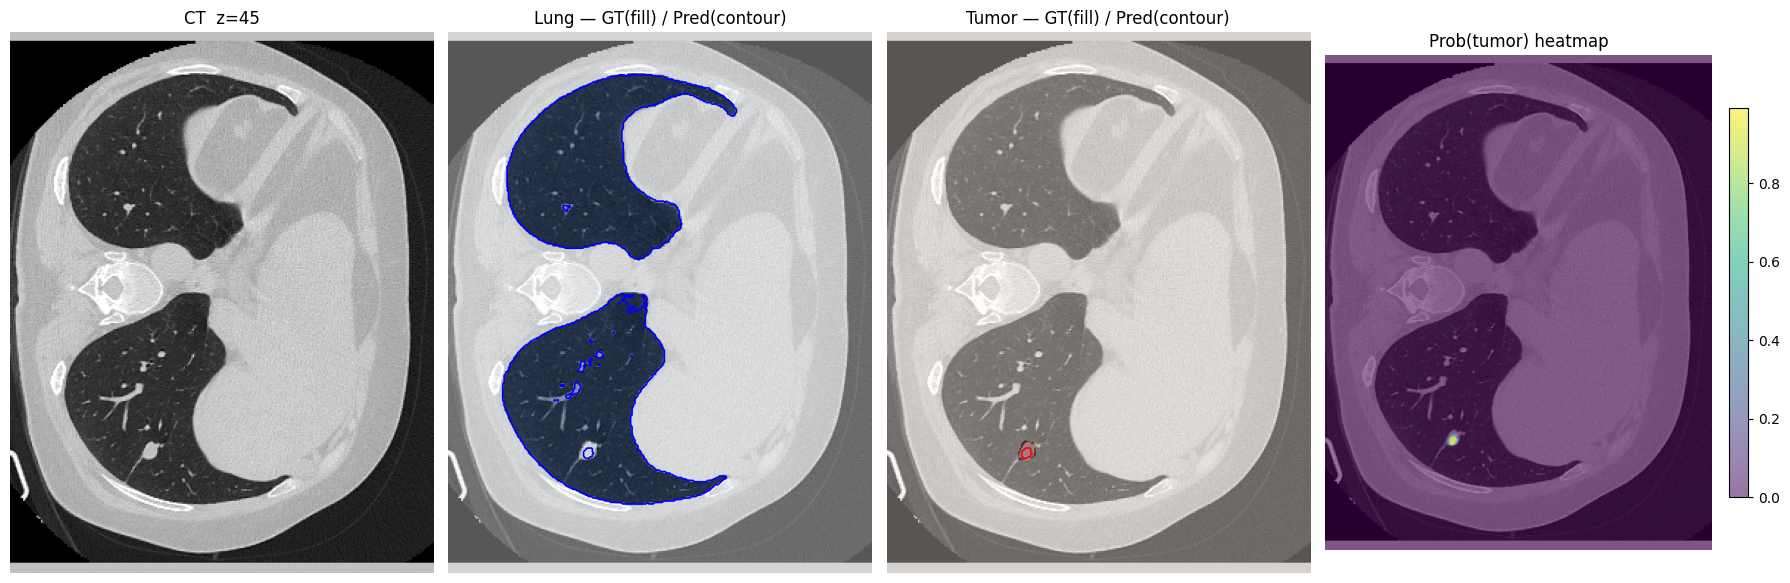

In [ ]:
#good prediction
image_path = r"C:\Users\aless\Desktop\DATASET_lung\converted_nii\images\LNDb-0157.nii.gz"
label_path = r"C:\Users\aless\Desktop\DATASET_lung\converted_nii\multiclass\LNDb-0157.nii.gz"
model_path = r"C:\Users\aless\Desktop\DATASET_lung\checkpoint\best_model.pt"

data_dict = [{"image": image_path, "label": label_path}]
ds = Dataset(data=data_dict, transform=inference_transform)
loader = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)
state = torch.load(model_path, map_location=device)
if isinstance(state, dict) and "model_state_dict" in state:
    model.load_state_dict(state["model_state_dict"])
else:
    model.load_state_dict(state)
model.eval()
# ----------------------------

with torch.no_grad():
    batch = next(iter(loader))
    img_t = batch["image"].to(device)             # [1,1,H,W,D]
    lab   = batch["label"].cpu().numpy().squeeze()  # [H,W,D]
    img_np= img_t.cpu().numpy()[0,0]

    logits = sliding_window_inference(
        inputs=img_t, roi_size=roi_size, sw_batch_size=1,
        predictor=model, overlap=0.75, mode="gaussian"
    )
    probs = torch.softmax(logits, dim=1)          # [1,3,H,W,D]
    pred  = torch.argmax(probs, dim=1).cpu().numpy().squeeze()

    ch_means = probs.mean(dim=(0,2,3,4)).cpu().numpy()
    print("Mean softmax [bg, lung, tumor]:", np.round(ch_means, 4))
    print("GT unique:", np.unique(lab), "| Pred unique:", np.unique(pred))
    print("Lung vox GT/Pred:", int((lab==1).sum()), int((pred==1).sum()))
    print("Tumor vox GT/Pred:", int((lab==2).sum()), int((pred==2).sum()))

    dl = dice_bin(pred==1, lab==1)
    dt = dice_bin(pred==2, lab==2)
    print(f"Dice lung (vol):  {dl:.4f}")
    print(f"Dice tumor (vol): {dt:.4f}")

    gt_area   = (lab==2).sum(axis=(0,1))
    pr_area   = (pred==2).sum(axis=(0,1))
    if gt_area.sum() > 0:
        z = int(np.argmax(gt_area)); src = "GT-top"
    elif pr_area.sum() > 0:
        z = int(np.argmax(pr_area)); src = "Pred-top"
    else:
        z = lab.shape[-1]//2;        src = "middle (no tumor)"
    print(f"Slice z={z} (source: {src})")

    ct   = img_np[:,:,z]
    gt_l = (lab==1)[:,:,z]
    gt_t = (lab==2)[:,:,z]
    pr_l = (pred==1)[:,:,z]
    pr_t = (pred==2)[:,:,z]
    p_t  = probs[0,2].cpu().numpy()[:,:,z]  # prob(tumor)

    plt.figure(figsize=(18,6))

    plt.subplot(1,4,1)
    plt.imshow(ct, cmap="gray")
    plt.title(f"CT  z={z}")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_l, "Lung — GT(fill) / Pred(contour)", cmap="Blues", alpha=0.35)
    if pr_l.any():
        plt.contour(pr_l.astype(np.float32), levels=[0.5], colors='blue', linewidths=1.2)

    plt.subplot(1,4,3)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_t, "Tumor — GT(fill) / Pred(contour)", cmap="Reds", alpha=0.35)
    if pr_t.any():
        plt.contour(pr_t.astype(np.float32), levels=[0.5], colors='red', linewidths=1.2)

    plt.subplot(1,4,4)
    plt.imshow(ct, cmap="gray")
    im = plt.imshow(p_t, alpha=0.55)
    plt.title("Prob(tumor) heatmap")
    plt.axis("off")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


Mean softmax [bg, lung, tumor]: [0.8377 0.1623 0.    ]
GT unique: [0. 1. 2.] | Pred unique: [0 1 2]
Lung vox GT/Pred: 5276969 5224627
Tumor vox GT/Pred: 6197 432
Dice lung (vol):  0.9864
Dice tumor (vol): 0.0000
Slice z=228 (source: GT-top)


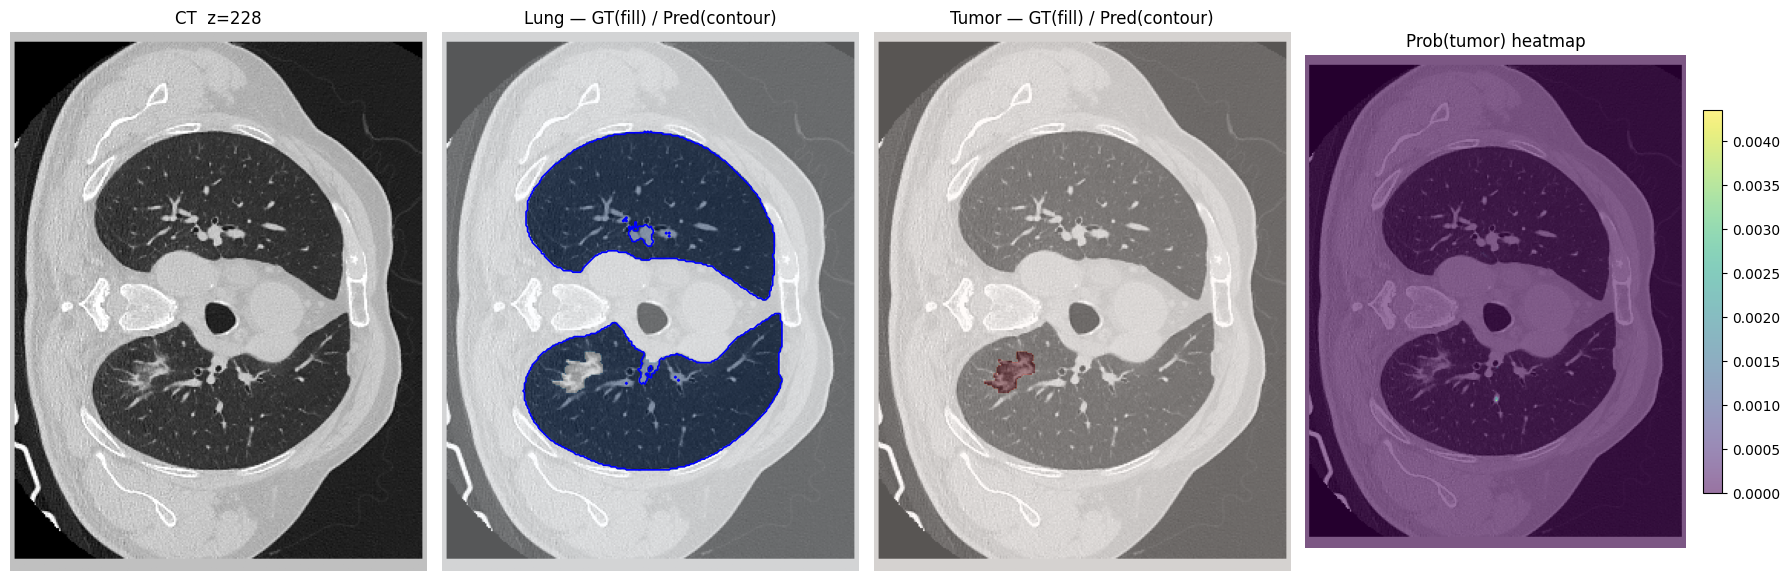

In [ ]:
#spiculazioni /GNN
image_path = r"C:\Users\aless\Desktop\DATASET_lung\converted_nii\images\LNDb-0251.nii.gz"
label_path = r"C:\Users\aless\Desktop\DATASET_lung\converted_nii\multiclass\LNDb-0251.nii.gz"
model_path = r"C:\Users\aless\Desktop\DATASET_lung\checkpoint\best_model.pt"

data_dict = [{"image": image_path, "label": label_path}]
ds = Dataset(data=data_dict, transform=inference_transform)
loader = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)
state = torch.load(model_path, map_location=device)
if isinstance(state, dict) and "model_state_dict" in state:
    model.load_state_dict(state["model_state_dict"])
else:
    model.load_state_dict(state)
model.eval()
# ----------------------------

with torch.no_grad():
    batch = next(iter(loader))
    img_t = batch["image"].to(device)             # [1,1,H,W,D]
    lab   = batch["label"].cpu().numpy().squeeze()  # [H,W,D]
    img_np= img_t.cpu().numpy()[0,0]

    logits = sliding_window_inference(
        inputs=img_t, roi_size=roi_size, sw_batch_size=1,
        predictor=model, overlap=0.75, mode="gaussian"
    )
    probs = torch.softmax(logits, dim=1)          # [1,3,H,W,D]
    pred  = torch.argmax(probs, dim=1).cpu().numpy().squeeze()

    ch_means = probs.mean(dim=(0,2,3,4)).cpu().numpy()
    print("Mean softmax [bg, lung, tumor]:", np.round(ch_means, 4))
    print("GT unique:", np.unique(lab), "| Pred unique:", np.unique(pred))
    print("Lung vox GT/Pred:", int((lab==1).sum()), int((pred==1).sum()))
    print("Tumor vox GT/Pred:", int((lab==2).sum()), int((pred==2).sum()))

    dl = dice_bin(pred==1, lab==1)
    dt = dice_bin(pred==2, lab==2)
    print(f"Dice lung (vol):  {dl:.4f}")
    print(f"Dice tumor (vol): {dt:.4f}")

    gt_area   = (lab==2).sum(axis=(0,1))
    pr_area   = (pred==2).sum(axis=(0,1))
    if gt_area.sum() > 0:
        z = int(np.argmax(gt_area)); src = "GT-top"
    elif pr_area.sum() > 0:
        z = int(np.argmax(pr_area)); src = "Pred-top"
    else:
        z = lab.shape[-1]//2;        src = "middle (no tumor)"
    print(f"Slice z={z} (source: {src})")

    ct   = img_np[:,:,z]
    gt_l = (lab==1)[:,:,z]
    gt_t = (lab==2)[:,:,z]
    pr_l = (pred==1)[:,:,z]
    pr_t = (pred==2)[:,:,z]
    p_t  = probs[0,2].cpu().numpy()[:,:,z]  # prob(tumor)

    plt.figure(figsize=(18,6))

    plt.subplot(1,4,1)
    plt.imshow(ct, cmap="gray")
    plt.title(f"CT  z={z}")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_l, "Lung — GT(fill) / Pred(contour)", cmap="Blues", alpha=0.35)
    if pr_l.any():
        plt.contour(pr_l.astype(np.float32), levels=[0.5], colors='blue', linewidths=1.2)

    plt.subplot(1,4,3)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_t, "Tumor — GT(fill) / Pred(contour)", cmap="Reds", alpha=0.35)
    if pr_t.any():
        plt.contour(pr_t.astype(np.float32), levels=[0.5], colors='red', linewidths=1.2)

    plt.subplot(1,4,4)
    plt.imshow(ct, cmap="gray")
    im = plt.imshow(p_t, alpha=0.55)
    plt.title("Prob(tumor) heatmap")
    plt.axis("off")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


Mean softmax [bg, lung, tumor]: [0.8029 0.197  0.    ]
GT unique: [0. 1. 2.] | Pred unique: [0 1 2]
Lung vox GT/Pred: 9014898 8568767
Tumor vox GT/Pred: 304 549
Dice lung (vol):  0.9640
Dice tumor (vol): 0.0000
Slice z=285 (source: GT-top)


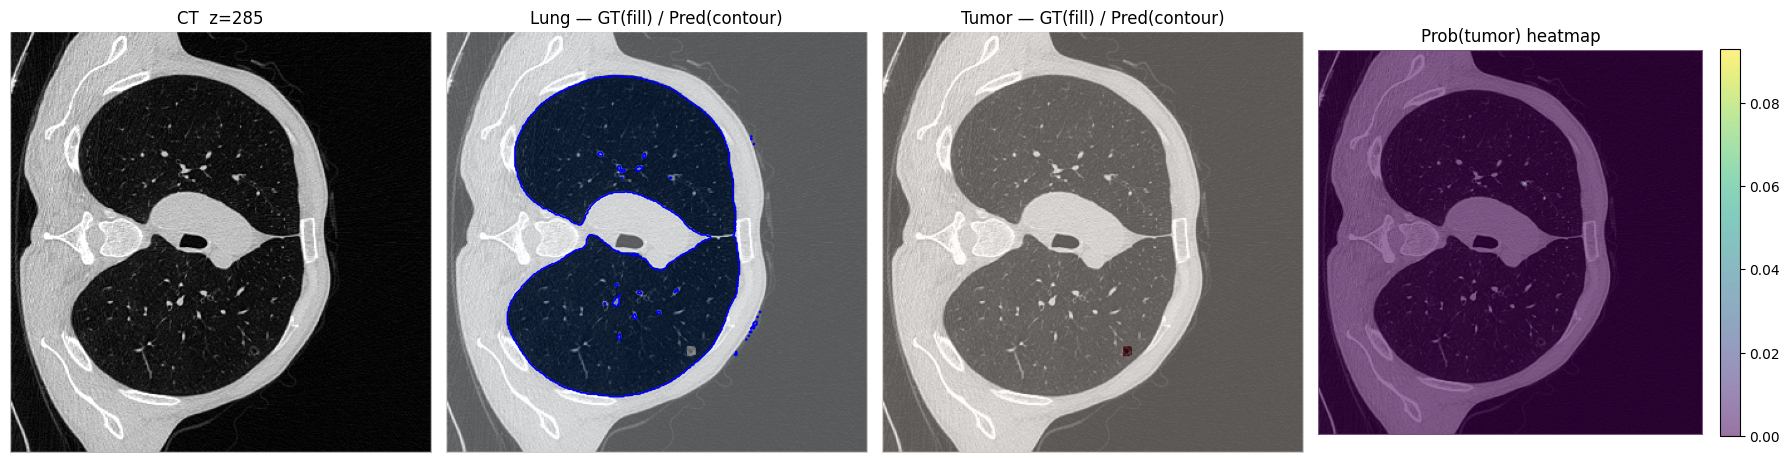

In [ ]:
#cavitated
image_path = r"C:\Users\aless\Desktop\DATASET_lung\converted_nii\images\LNDb-0013.nii.gz"
label_path = r"C:\Users\aless\Desktop\DATASET_lung\converted_nii\multiclass\LNDb-0013.nii.gz"
model_path = r"C:\Users\aless\Desktop\DATASET_lung\checkpoint\best_model.pt"

data_dict = [{"image": image_path, "label": label_path}]
ds = Dataset(data=data_dict, transform=inference_transform)
loader = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)
state = torch.load(model_path, map_location=device)
if isinstance(state, dict) and "model_state_dict" in state:
    model.load_state_dict(state["model_state_dict"])
else:
    model.load_state_dict(state)
model.eval()
# ----------------------------

with torch.no_grad():
    batch = next(iter(loader))
    img_t = batch["image"].to(device)             # [1,1,H,W,D]
    lab   = batch["label"].cpu().numpy().squeeze()  # [H,W,D]
    img_np= img_t.cpu().numpy()[0,0]

    logits = sliding_window_inference(
        inputs=img_t, roi_size=roi_size, sw_batch_size=1,
        predictor=model, overlap=0.75, mode="gaussian"
    )
    probs = torch.softmax(logits, dim=1)          # [1,3,H,W,D]
    pred  = torch.argmax(probs, dim=1).cpu().numpy().squeeze()

    ch_means = probs.mean(dim=(0,2,3,4)).cpu().numpy()
    print("Mean softmax [bg, lung, tumor]:", np.round(ch_means, 4))
    print("GT unique:", np.unique(lab), "| Pred unique:", np.unique(pred))
    print("Lung vox GT/Pred:", int((lab==1).sum()), int((pred==1).sum()))
    print("Tumor vox GT/Pred:", int((lab==2).sum()), int((pred==2).sum()))

    dl = dice_bin(pred==1, lab==1)
    dt = dice_bin(pred==2, lab==2)
    print(f"Dice lung (vol):  {dl:.4f}")
    print(f"Dice tumor (vol): {dt:.4f}")

    gt_area   = (lab==2).sum(axis=(0,1))
    pr_area   = (pred==2).sum(axis=(0,1))
    if gt_area.sum() > 0:
        z = int(np.argmax(gt_area)); src = "GT-top"
    elif pr_area.sum() > 0:
        z = int(np.argmax(pr_area)); src = "Pred-top"
    else:
        z = lab.shape[-1]//2;        src = "middle (no tumor)"
    print(f"Slice z={z} (source: {src})")

    ct   = img_np[:,:,z]
    gt_l = (lab==1)[:,:,z]
    gt_t = (lab==2)[:,:,z]
    pr_l = (pred==1)[:,:,z]
    pr_t = (pred==2)[:,:,z]
    p_t  = probs[0,2].cpu().numpy()[:,:,z]

    plt.figure(figsize=(18,6))

    plt.subplot(1,4,1)
    plt.imshow(ct, cmap="gray")
    plt.title(f"CT  z={z}")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_l, "Lung — GT(fill) / Pred(contour)", cmap="Blues", alpha=0.35)
    if pr_l.any():
        plt.contour(pr_l.astype(np.float32), levels=[0.5], colors='blue', linewidths=1.2)

    plt.subplot(1,4,3)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_t, "Tumor — GT(fill) / Pred(contour)", cmap="Reds", alpha=0.35)
    if pr_t.any():
        plt.contour(pr_t.astype(np.float32), levels=[0.5], colors='red', linewidths=1.2)

    plt.subplot(1,4,4)
    plt.imshow(ct, cmap="gray")
    im = plt.imshow(p_t, alpha=0.55)
    plt.title("Prob(tumor) heatmap")
    plt.axis("off")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
